# 映画レビューデータを通したデータ処理演習
参考サイト: [Collaborative Filtering for Movie Recommendations](https://keras.io/examples/structured_data/collaborative_filtering_movielens/)



## ゴール
CSV/TSV等のテキストファイルで用意された生のデータの読み込み方、そこから必要な項目を抽出するようなデータ処理、平均値・分散値を算出したりといった一般的な統計処理、グラフや分布図等の描画方法について学んでみましょう。

なお、[MovieLens](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html)と呼ばれる映画レビューデータセットを元に、似ているユーザを探し出し、そのユーザが高評価を付けているまだ視聴していない映画を抽出する映画推薦の例も示します。重要なのは個々のコードを覚えることではなく、必要なことを自身で検索して探し出し、参考にして実装できるようになることです。

例えば ``pandas cheat sheet`` ぐらいでググると[Pandas Cheat Sheet for Data Science in Python](https://www.datacamp.com/community/blog/python-pandas-cheat-sheet)が見つかります。[pandas 列抽出](https://www.google.com/search?client=safari&sxsrf=ALeKk028LUPdRcMxKct-InRUlXvrhXEgWw%3A1615257233990&source=hp&ei=kd5GYNueOvmSr7wP3_WNmAs&iflsig=AINFCbYAAAAAYEbsoREhVTNrmXyCWNHJNO6v4L0YKjwL&q=pandas+%E5%88%97%E6%8A%BD%E5%87%BA&oq=pandas+%E5%88%97%E6%8A%BD%E5%87%BA&gs_lcp=Cgdnd3Mtd2l6EAMyAggAMgIIADICCAAyAggAMgIIADoECAAQBDoICAAQsQMQgwE6BwgAELEDEAQ6CggAELEDEIMBEAQ6BQgAELEDOgYIABAEEAM6CAgAEAQQChAqOgYIABAEEAo6CAgAEAQQChAeOgUIIRCgAToGCAAQBBAeUKoGWOpzYNJ1aAlwAHgBgAHpAYgBhB-SAQY0LjMxLjGYAQCgAQGqAQdnd3Mtd2l6&sclient=gws-wiz&ved=0ahUKEwibq5qNlqLvAhV5yYsBHd96A7MQ4dUDCAw&uact=5)ならこういう結果が得られます。検索上手になろう。


## 利用パッケージと公式ドキュメントやチュートリアル
すべてを使いこなすのではなく、必要な時に必要なものを探し出せるようになろう。

- Python標準モジュール
  - [zipfile](https://docs.python.org/ja/3/library/zipfile.html): ZIPアーカイブの処理。
  - [pathlib](https://docs.python.org/ja/3/library/pathlib.html): ファイルパス処理。
  - [io](https://docs.python.org/ja/3/library/io.html): 入出力処理。
- 外部パッケージ
  - requests: HTTPライブラリ。
    - [クイックスタート](https://requests-docs-ja.readthedocs.io/en/latest/user/quickstart/)
  - numpy: 数値演算・行列演算ライブラリ。
    - [quickstart](https://docs.scipy.org/doc/numpy/user/quickstart.html) | [tutorial](https://avinton.com/python-numpy-tutorial-japanese/)
  - pandas: 表形式データ操作ライブラリ。
    - [tutorial](https://pandas.pydata.org/pandas-docs/stable/tutorials.html) | [10 Minutes to pandas](https://pandas.pydata.org/pandas-docs/stable/10min.html)
  - matplotlib: 可視化ライブラリ。
    - [tutorial](https://matplotlib.org/stable/tutorials/index.html)
  - seaborn: 可視化ライブラリ。
    - [tutorial](https://seaborn.pydata.org/tutorial.html)
- Linuxコマンド
  - ls: ファイル一覧をリスト表示。Windowsのdir相当。
  - tree: 階層構造を可視化。

In [75]:
# Python標準モジュール
#from zipfile import ZipFile
from pathlib import Path
import zipfile, io

# 外部パッケージ
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## データセットの準備

### データセットのダウンロード
今回利用するデータセットは [MovieLens](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html) の最小データセットを利用する。MovieLensは、視聴者による映画に対する5点満点のレビューを収集して構築したものであり、「ユーザ1番は映画500番に対して4点を付けた」というデータの集合になっている。またユーザの嗜好や映画の属性についてもある程度判断するための情報として、ユーザは年齢・性別、映画はタイトル・カテゴリ・出版年が付与されている。

In [76]:
#!curl -O http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

!apt install tree
#!rm -rf *

#import requests, zipfile, io

movielens_zipfile_url = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
save_path = "./"
r = requests.get(movielens_zipfile_url)
print(r)
print(type(r))
print(r.content)

zfile = zipfile.ZipFile(io.BytesIO(r.content))
zfile.extractall(save_path)

!ls
!ls ml-latest-small/*
!tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



ml-latest-small/links.csv    ml-latest-small/README.txt
ml-latest-small/movies.csv   ml-latest-small/tags.csv
ml-latest-small/ratings.csv
.
├── ml-latest-small
│   ├── links.csv
│   ├── movies.csv
│   ├── ratings.csv
│   ├── README.txt
│   └── tags.csv
└── sample_data
    ├── anscombe.json
    ├── california_housing_test.csv
    ├── california_housing_train.csv
    ├── mnist_test.csv
    ├── mnist_train_small.csv
    └── README.md

2 directories, 11 files


### CSVファイルをpd.DataFrameに変換し覗いてみる
pandasではデータセットを[DataFrame型](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)と呼ばれる二次元表形式の構造でデータを管理し、処理することが多い。

表をExcelのような表計算ソフトで処理する場合には「行方向インデックス（1〜N）」「列方向インデックス（A〜AZ,,,）」を用いて対象セルを指定し、平均値や分散を求めたり、特定条件に合致する値を抽出して処理することになる。

ここでは代表的な行・列指定方法、値の参照方法を眺めていこう。

- 参考: ml-latest-small詳細: [ml-latest-small-README.html](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html)
- tips
  - ``pd.reac_csv('filename')`` でCSVやTSV形式のファイルを読み込むことができる。なおファイル冒頭に列名が記載されている場合にはそれを列名として読み取ることもできるし、逆にそれをスキップすることもできる。詳細は[ドキュメント](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)で確認しよう。
  - DataFrameに対して ``head()`` で冒頭5個までのデータを眺めることができる。大規模データを全出力しても意味がないため、ざっくりと確認したい場合に便利。
  - 今回のデータセットは以下の4つのデータフレームで構成されている。これらを組み合わせて利用すると、例えば「movieId==1は'Toy Story (1995)'で、そのカテゴリは Adventure等複数が付与されている。より詳細情報は[imdbで114709](https://www.imdb.com/title/tt0114709/)から参照できる。この映画に対してuserId==1は4点を付けている」といったことを読み出すことができる。たかだか4つのファイルでも頭の中で組み合わせて考えるのは難しいので、自分なりに図を書いてどう関連しているかを鳥瞰しやすくしよう。
	- links: movieId, imdbId, tmdbId
	- movies: movieId, title, genres
	- ratings: userId, movieId, rating, timestamp
	- tags: userId, movieId, tag, timestamp

In [77]:
links = pd.read_csv('ml-latest-small/links.csv')
print(type(links))
links.head()

<class 'pandas.core.frame.DataFrame'>


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [78]:
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [79]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [80]:
tags = pd.read_csv('ml-latest-small/tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


## 行や列を指定した簡易処理

### 特定の行（サンプル）や列（特徴）を指定して眺めてみる
moviesはmovieId, title, genresの3要素で構成されるデータが並んでいる。ここではtitleだけを指定し、かつ、冒頭5番目までのデータを出力指定している。

- tips
  - DataFrameに対して ``['列名']`` で列を指定できる。
  - DataFrameに対して ``[start:end]`` のようにスライス処理（これはPythonのリストに対する処理と同等）を記述することで、連続した複数行を指定できる。startを省略した場合は冒頭から、endを省略した場合は最後までという意味になる。

In [81]:
print(movies.columns)
print(movies['title'][:5])

Index(['movieId', 'title', 'genres'], dtype='object')
0                      Toy Story (1995)
1                        Jumanji (1995)
2               Grumpier Old Men (1995)
3              Waiting to Exhale (1995)
4    Father of the Bride Part II (1995)
Name: title, dtype: object


In [82]:
print(movies.loc[:5])

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   
5        6                         Heat (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
5                        Action|Crime|Thriller  


In [83]:
# 省略させずに全て表示させるにはオプション設定が必要。
# これはnumpyでも同様。
pd.set_option('display.max_columns', 10)
print(movies.loc[:5])

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   
5        6                         Heat (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
5                        Action|Crime|Thriller  


### 条件を指定して眺めてみる1（userId == 1 のレーティングを確認）

In [84]:
# 条件式だけではTrue/Falseという判断結果しか出力されない。
print(ratings['userId'] == 1)

0          True
1          True
2          True
3          True
4          True
          ...  
100831    False
100832    False
100833    False
100834    False
100835    False
Name: userId, Length: 100836, dtype: bool


In [85]:
# 判断結果に基づいて合致する行を調べるには、同じDataFrameを参照し直す必要がある。
print(ratings[ratings['userId'] == 1])

     userId  movieId  rating  timestamp
0         1        1     4.0  964982703
1         1        3     4.0  964981247
2         1        6     4.0  964982224
3         1       47     5.0  964983815
4         1       50     5.0  964982931
..      ...      ...     ...        ...
227       1     3744     4.0  964980694
228       1     3793     5.0  964981855
229       1     3809     4.0  964981220
230       1     4006     4.0  964982903
231       1     5060     5.0  964984002

[232 rows x 4 columns]


### 数値情報の概要（出現回数・平均・分散・最小値・最大値・四分位数）を眺めてみる

In [86]:
ratings['rating'].mean()

3.501556983616962

In [87]:
ratings['rating'].std()

1.0425292390605359

In [88]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.00,100836.00,100836.00,1.01e+05
mean,326.13,19435.30,3.50,1.21e+09
std,182.62,35530.99,1.04,2.16e+08
min,1.00,1.00,0.50,8.28e+08
25%,177.00,1199.00,3.00,1.02e+09
50%,325.00,2991.00,3.50,1.19e+09
75%,477.00,8122.00,4.00,1.44e+09
max,610.00,193609.00,5.00,1.54e+09


In [89]:
# userId == 1の概要
df = ratings[ratings['userId'] == 1]
df.describe()

,userId,movieId,rating,timestamp
count,232.0,232.00,232.00,2.32e+02
mean,1.0,1854.60,4.37,9.65e+08
std,0.0,1055.96,0.80,4.84e+04
min,1.0,1.00,1.00,9.65e+08
25%,1.0,1047.25,4.00,9.65e+08
50%,1.0,1960.50,5.00,9.65e+08
75%,1.0,2641.75,5.00,9.65e+08
max,1.0,5060.00,5.00,9.66e+08


In [90]:
# レーティングの値は1〜5の整数値。
# その平均値や分散に小数点下5桁とかの意味はある？
# 必要に応じて出力桁を調整するか、値そのものを調整することがある。
# ここでは値はそのままにし、print出力時の表示のみ調整しよう。
pd.options.display.precision = 2
df.describe()

,userId,movieId,rating,timestamp
count,232.0,232.00,232.00,2.32e+02
mean,1.0,1854.60,4.37,9.65e+08
std,0.0,1055.96,0.80,4.84e+04
min,1.0,1.00,1.00,9.65e+08
25%,1.0,1047.25,4.00,9.65e+08
50%,1.0,1960.50,5.00,9.65e+08
75%,1.0,2641.75,5.00,9.65e+08
max,1.0,5060.00,5.00,9.66e+08


## 大雑把に可視化してみる
- tips
  - DataFrameに対して[plot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html)でグラフ描画できる。ただし全ての数値をプロット対象とするため、必要に応じて指定した方が良い。
  - [seaborn](https://seaborn.pydata.org)も便利。ここでは箱ひげ図出力に使っていますが、上記のDataFrame.plotでも箱ひげ図自体は作図できます。

### pd.plotでグラフ描画

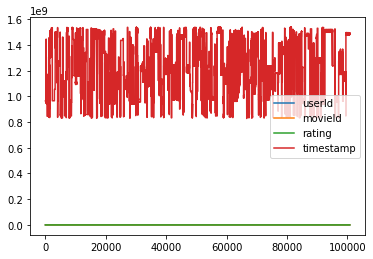

In [91]:
# DataFrameに対してplot()を実行すると、
# 数値データを全て折れ線グラフで出力する。

ratings.plot()

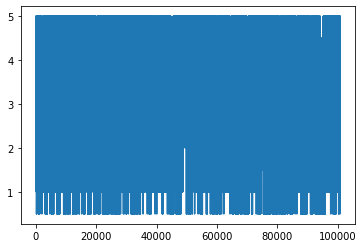

In [92]:
# 集計と同様にカラム指定も可能。

ratings['rating'].plot()

### 条件絞り込んでpd.plot

       userId  movieId  rating   timestamp
0           1        1     4.0   964982703
516         5        1     4.0   847434962
874         7        1     4.5  1106635946
1434       15        1     2.5  1510577970
1667       17        1     4.5  1305696483
...       ...      ...     ...         ...
97364     606        1     2.5  1349082950
98479     607        1     4.0   964744033
98666     608        1     2.5  1117408267
99497     609        1     3.0   847221025
99534     610        1     5.0  1479542900

[215 rows x 4 columns]


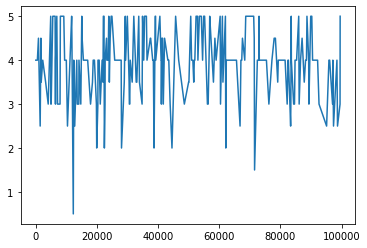

In [93]:
# movieId == 1 だけ抽出

temp = ratings[ ratings['movieId']==1 ]
print(temp)
temp.describe()
temp['rating'].plot()

### pd.plot(kind='hist')でヒストグラム

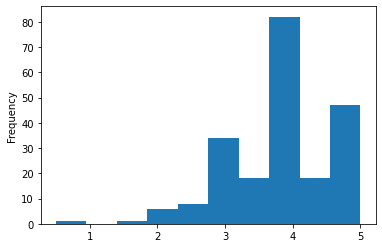

In [94]:
# 折れ線グラフでは良く分からないのでヒストグラムにしてみる。

temp['rating'].plot(kind='hist')

### seaborn.boxplot で箱ひげ図

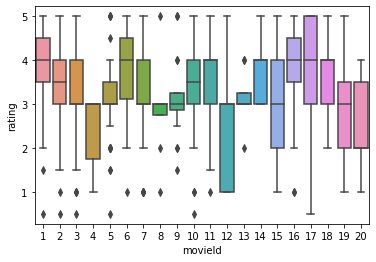

In [95]:
# 映画毎の箱ひげ図を出力してみる。
# 全ての映画を出力すると圧縮されすぎて目視できないため、ここではmovieId=1〜20までを指定。

temp = ratings[ratings['movieId'] <= 20]
sns.boxplot(x='movieId', y='rating', data=temp)

## テーブルを組み合わせるてみる
ユーザを行、列を映画とする行列を作成し、各要素の値をratingとする（ない場合にはNoneにする）。これをユーザ・映画行列と呼ぶことにしよう。ユーザ・映画行列を用意できれば「同じ映画集合に対して高評価を付けているユーザグループ」を抽出できるかもしれない。そのようなグループを抽出できたならば「同じグループが高評価しているが、まだ評価されていない映画」を発見することで高評価を得やすい映画を推薦できるだろう。このように映画の視聴履歴を元に推薦する方法を[協調フィルタリング](https://www.ai-gakkai.or.jp/whatsai/AItopics2.html)と呼ぶ。

今は詳細を省くが、以下の手順で視聴履歴を利用してみよう。

- step 1: ユーザ・映画行列を作成。
- step 2: ユーザ間の類似度を算出。
- step 3: あるユーザiに対する最大類似度となるユーザjを抽出。
- step 4: ユーザjが高く評価している映画をリストアップ。
- step 5: リストアップした映画からユーザiが見ていないもの（＝推薦候補）を抽出。

### step 1: ユーザ・映画行列を作成。
- ``NaN`` は Not a Number の略。数値ではない値のこと。ここでは該当要素に値がなかった場合のデフォルト値として設定されている。
- [pd.pivot_table](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html)でピボットテーブルを作成。

In [96]:
df = ratings.pivot_table(index='userId', columns='movieId', values='rating')
df

movieId,1,2,3,4,5,...,193581,193583,193585,193587,193609
userId,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN


In [97]:
df.describe()

movieId,1,2,3,4,5,...,193581,193583,193585,193587,193609
count,215.00,110.00,52.00,7.00,49.00,...,1.0,1.0,1.0,1.0,1.0
mean,3.92,3.43,3.26,2.36,3.07,...,4.0,3.5,3.5,3.5,4.0
std,0.83,0.88,1.05,0.85,0.91,...,NaN,NaN,NaN,NaN,NaN
min,0.50,0.50,0.50,1.00,0.50,...,4.0,3.5,3.5,3.5,4.0
25%,3.50,3.00,3.00,1.75,3.00,...,4.0,3.5,3.5,3.5,4.0
50%,4.00,3.50,3.00,3.00,3.00,...,4.0,3.5,3.5,3.5,4.0
75%,4.50,4.00,4.00,3.00,3.50,...,4.0,3.5,3.5,3.5,4.0
max,5.00,5.00,5.00,3.00,5.00,...,4.0,3.5,3.5,3.5,4.0


### step 2: ユーザ間の類似度を算出。
ユーザ間類似度は「評価値の二乗誤差」を用いることにしよう。同じ映画を見ているとは限らないため、視聴映画リストで重複している映画だけを抽出し、誤差を算出する必要がある。
- [df.notnull](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.notnull.html)で欠損値を除外。
- [df.index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.index.html)で該当列インデックスを参照。
- [set.intersection](https://docs.python.org/ja/3/library/stdtypes.html#frozenset.intersection)で共通集合を抽出。
- [np.array](https://numpy.org/doc/stable/reference/generated/numpy.array.html)でnumpy用配列（ndarray）型に変換。
- [np.dot](https://numpy.org/doc/stable/reference/generated/numpy.dot.html)で内積計算。
- [np.linalg.norm](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html#numpy.linalg.norm)でベクトルのノルム（大きさ）計算。

In [98]:
# userId==1が見た映画リストを抽出。
# NaN（Not a Number）を除外したもの。

print(df.loc[1]) # userId==1の視聴履歴
print(df.loc[1].notnull()) # 値の有無
print(df.loc[1][df.loc[1].notnull()]) # 値の有るもの
print(df.loc[1][df.loc[1].notnull()].index) # 値の有るmovieId

movieId
1         4.0
2         NaN
3         4.0
4         NaN
5         NaN
         ... 
193581    NaN
193583    NaN
193585    NaN
193587    NaN
193609    NaN
Name: 1, Length: 9724, dtype: float64
movieId
1          True
2         False
3          True
4         False
5         False
          ...  
193581    False
193583    False
193585    False
193587    False
193609    False
Name: 1, Length: 9724, dtype: bool
movieId
1       4.0
3       4.0
6       4.0
47      5.0
50      5.0
       ... 
3744    4.0
3793    5.0
3809    4.0
4006    4.0
5060    5.0
Name: 1, Length: 232, dtype: float64
Int64Index([   1,    3,    6,   47,   50,   70,  101,  110,  151,  157,
            ...
            3671, 3702, 3703, 3729, 3740, 3744, 3793, 3809, 4006, 5060],
           dtype='int64', name='movieId', length=232)


In [99]:
# 映画リストを基準にしたuserId==1の評価値を参照する方法。
index = set(df.loc[1][df.loc[1].notnull()].index)
df.loc[1][index]

movieId
1024    5.0
1       4.0
1025    5.0
3       4.0
2048    5.0
       ... 
500     3.0
3062    4.0
3578    5.0
2046    4.0
1023    5.0
Name: 1, Length: 232, dtype: float64

In [100]:
# userId=1と2で重複するインデックスを抽出する方法。
index1 = set(df.loc[1][df.loc[1].notnull()].index)
index2 = set(df.loc[2][df.loc[2].notnull()].index)
common_index = index1.intersection(index2)
print(len(index1), len(index2))
print(len(common_index))
print(common_index)

232 29
2
{3578, 333}


In [101]:
# ユーザ間類似度は「評価値の二乗誤差」を用いることにしよう。
# 同じ映画を見ているとは限らないため、
# 視聴映画リストで重複している映画だけを抽出し、誤差を算出する必要がある。

def get_similarity(person1, person2, dataset):
  # person1とperson2の映画リスト
  movies1 = dataset.loc[person1][dataset.loc[person1].notnull()].index
  movies2 = dataset.loc[person2][dataset.loc[person2].notnull()].index

  # 共通映画リスト
  movies1 = set(movies1)
  movies2 = set(movies2)
  both_movies = movies1.intersection(movies2)

  # 共通リストがない場合
  if len(both_movies) == 0:
    return 0
  
  #print('{}, {}: len(person1)={}, len(person2)={}, len(both_movies)={}'.format(person1, person2, len(movies1), len(movies2), len(both_movies)))
  
  # 共通リストがある場合
  vector1 = np.array(dataset.loc[person1][both_movies])
  vector2 = np.array(dataset.loc[person2][both_movies])
  #print(type(vector1), vector1.shape)

  nominator = np.dot(vector1, vector2)
  denominator = np.linalg.norm(vector1) * np.linalg.norm(vector2)
  similarity = nominator / denominator
  return similarity

print(get_similarity(1, 1, df)) #同じユーザ同士なら類似度1
print(get_similarity(1, 2, df))
print(get_similarity(2, 1, df)) #違うユーザを順番入れ替えて測っても同じ類似度が出ることを確認


1.0
0.9999999999999998
0.9999999999999998


### step 3: あるユーザiに対する最大類似度となるユーザjを抽出。


In [102]:
# コード確認用に小規模データセットを乱数で用意。
# 乱数のため実行する度に値が変わることを確認しよう。
data = np.random.randn(5)
print(data)


[ 0.51421884  0.22117967 -1.07004333 -0.18949583  0.25500144]


In [103]:
# トラブルシューティング等、乱数であってもそれを再現したいことがある。
# このような場合にはシード値を与えて実行する。
# シード値を固定しておけば何度実行しても同じ値が再現できることを確認しよう。
np.random.seed(100) # この値（シード値）は何でも良い。
data = np.random.randn(5)
print(data)


[-1.74976547  0.3426804   1.1530358  -0.25243604  0.98132079]


In [104]:

# 上位k件の「未ソート」インデックス
k = 3
indices = np.argpartition(-data, k)[:k]
print(indices)

# 上位k件の「ソート済み」インデックス
indices = indices[np.argsort(-data[indices])]
print(indices)

# 上位k件の値
print(data[indices])

[2 4 1]
[2 4 1]
[1.1530358  0.98132079 0.3426804 ]


In [105]:
# 大きい順にソートし、インデックスを取得

def get_top_k(data, top=3):
  indices = np.argpartition(-data, top)[:top]
  indices = indices[np.argsort(-data[indices])]
  return indices, data[indices]

for k in range(1,4):
  indices, top_k = get_top_k(data, k)
  print('k', k)
  print(indices)
  print(top_k)


k 1
[2]
[1.1530358]
k 2
[2 4]
[1.1530358  0.98132079]
k 3
[2 4 1]
[1.1530358  0.98132079 0.3426804 ]


In [106]:
def get_similarities_top_k(source, dataset, k=3):
  targets = list(dataset.index) # ユーザインデックスを取得

  # 類似度保存用配列を用意
  # 配列長を+1しているのは1番目から使うため。
  similarities = np.zeros(len(dataset)+1)

  # 全ユーザとの類似度算出
  for opponent in targets:
    if opponent == source:
      similarities[opponent] = 0. #自分自身は無視する
    else:
      similarities[opponent] = get_similarity(source, opponent, dataset)
  
  # 降順ソートして上位k人のidを取得
  indices, values = get_top_k(similarities, k)
  return indices, values

# userId==1との類似度上位ユーザを確認
k = 3
indices, values = get_similarities_top_k(1, df, k)
print('k', k)
print(indices)
print(values)


k 3
[383 388 184]
[1. 1. 1.]


### step 4: ユーザjが高く評価している映画をリストアップ。


In [107]:
# ユーザ383の評価とそのインデックス
user383_ratings = df.loc[383][df.loc[383].notnull()]
user383_ratings_indices = df.loc[383][df.loc[383].notnull()].index
print(user383_ratings[:5])
print(user383_ratings_indices)

movieId
150     4.0
539     4.0
903     4.0
1196    3.0
1234    3.0
Name: 383, dtype: float64
Int64Index([ 150,  539,  903, 1196, 1234, 1246, 1293, 1299, 1584, 1953, 1994,
            2324, 2396, 2436, 2445, 2447, 2496, 2501, 2506, 2539, 2541, 2546,
            2558, 2686, 2690, 2712, 2762, 2881, 2906, 2961, 2977, 2996, 3006,
            3115],
           dtype='int64', name='movieId')


In [108]:
# ユーザ383の上位評価を抽出
# get_top_k は与えた配列の中における順番を返してくるため、元のインデックスに換算し直す必要がある。
relative_indices, values = get_top_k(np.array(user383_ratings))
print(relative_indices)
print(values)

true_indices = user383_ratings_indices[relative_indices]
print(true_indices)
print(user383_ratings[true_indices])

[12  5 11]
[5. 5. 5.]
Int64Index([2396, 1246, 2324], dtype='int64', name='movieId')
movieId
2396    5.0
1246    5.0
2324    5.0
Name: 383, dtype: float64


In [109]:
def get_top_movies(target, df):
  # 対象ユーザの評価とそのインデックス
  user_ratings = df.loc[target][df.loc[target].notnull()]
  user_ratings_indices = df.loc[target][df.loc[target].notnull()].index

  # 対象ユーザの上位評価
  relative_indices, values = get_top_k(np.array(user_ratings))
  true_indices = user_ratings_indices[relative_indices]
  return true_indices, user_ratings[true_indices]

opponent = 383
indices, values = get_top_movies(opponent, df)
print(indices)
print(values)


Int64Index([2396, 1246, 2324], dtype='int64', name='movieId')
movieId
2396    5.0
1246    5.0
2324    5.0
Name: 383, dtype: float64


### step 5: リストアップした映画からユーザiが見ていないもの（＝推薦候補）を抽出。

In [110]:
# userId==1の視聴映画id
user1_indices = set(df.loc[1][df.loc[1].notnull()].index)
print(user1_indices)

# userId==383の高評価映画id
user383_indices = set(indices)
print(user383_indices)

# 高評価idのうち、userId==1がまだ視聴していないid
recommend_indices = user383_indices - user1_indices
print(recommend_indices)

{1024, 1, 1025, 3, 2048, 1029, 6, 1030, 1031, 1032, 2054, 2058, 2571, 527, 1552, 1042, 2580, 1049, 2078, 543, 3617, 1060, 1573, 2596, 552, 553, 2090, 1580, 2093, 2094, 47, 2096, 1073, 50, 1587, 2099, 3639, 1080, 2105, 2616, 2617, 1089, 1090, 2115, 1092, 2116, 70, 2628, 1097, 3147, 590, 592, 593, 1617, 2640, 596, 1620, 2641, 2644, 2648, 1625, 2137, 2139, 3671, 2141, 2654, 2143, 608, 2657, 3168, 101, 1127, 3176, 1644, 110, 1136, 2161, 3702, 3703, 2174, 2692, 648, 1676, 2700, 2193, 3729, 661, 151, 2716, 157, 3740, 3744, 673, 163, 3243, 1196, 1197, 1198, 3247, 3253, 1206, 1208, 1210, 1213, 1214, 1219, 1220, 1732, 1222, 1224, 2761, 1226, 3273, 2253, 3793, 216, 1240, 2268, 733, 223, 736, 2273, 3809, 231, 1256, 1258, 235, 2797, 1265, 1777, 2291, 1270, 1275, 1278, 1793, 1282, 260, 2826, 1291, 780, 1804, 1805, 1298, 2329, 2338, 804, 296, 2858, 2353, 2872, 3386, 316, 2366, 1348, 333, 2387, 2899, 2389, 2395, 349, 1377, 356, 2916, 2406, 362, 2414, 367, 3439, 3440, 3441, 1396, 3448, 3450, 2427, 140

In [111]:
def get_recommendation(source, opponent_indices, df):
  # userId==sourceの視聴映画id
  source_indices = set(df.loc[source][df.loc[source].notnull()].index)

  # 対象ユーザの高評価映画id
  opponent_indices = set(opponent_indices)

  # 高評価idのうち、userId==sourceがまだ視聴していないid
  recommend_indices = opponent_indices - source_indices
  return recommend_indices

userId = 1
opponent = 383
opponent_indices, values = get_top_movies(opponent, df)
recommend_indices = get_recommendation(userId, opponent_indices, df)
print(recommend_indices)

userId = 1
opponent = 388
opponent_indices, values = get_top_movies(opponent, df)
recommend_indices = get_recommendation(userId, opponent_indices, df)
print(recommend_indices)


{2396, 2324, 1246}
{8360, 4306, 33615}
